# Code

In [1]:
import numpy as np
import scipy.integrate as spi
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from sympy import *

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)
# init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

def StoichiometricMatix(rxns):
    """Returns the stoichiometric matrix for the given reactions.
       It is assumed that the reactions are in a list of reactions
       each ofthe form
          [ar, ap, rate_constant]
       where ar is the reactant vector and ap is the product vector.
    """
    vectors = [(-Matrix(a[0]) + Matrix(a[1])) for a in rxns]
    A = Matrix(vectors[0])
    for i in range(1,len(vectors)):
        A = A.col_insert(i,vectors[i])
    return A

def MAK(a,syms):
    """The mass action kinetics rate for the reaction a [ ar, ap, k ].
       syms should be a list of sympy symbols such as returned by var("x y z")"""
    rate = a[2] # k
    for r,s in zip(a[0],syms):
        rate = rate * s**r
    return rate

def KineticsVector(rxns,syms):
    """Builds the kinetics vector for the given reactions"""
    return Matrix([MAK(a,syms) for a in rxns])

def Dynamics(rxns,syms):
    """Builds the right hand side of the equation dv/dt = AK(v)"""
    return StoichiometricMatix(rxns) * KineticsVector(rxns,syms)

def ODEs(dynamics,syms):
    """Convertns the dynamics into a function that can be used with scipy's odeint function"""
    faux = lambdify([syms],dynamics,'numpy')
    def f(x,t):
        return faux(x).flatten()
    return f

def vectorize(species,names):
    a = [0 for s in species]
    for name in names:
        a[species.index(name)] += 1
    return a

def make_vectorizer(species):
    def f(*args):
        return vectorize(species, args)
    return f

# Fitting a Line

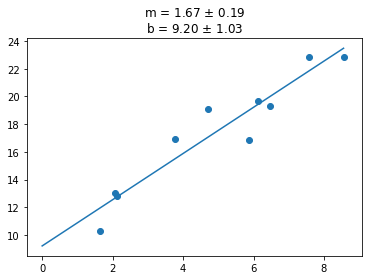

In [2]:
from lmfit import minimize, Parameters

xdata = np.sort([np.random.random()*10 for i in range(10)])
ydata = [5+5*np.random.random() + 2*x for x in xdata] 

def line(x,params):
    return params['m']*x+params['b']

def residual(params,f,x,y):
    return [ f(q[0],params) - q[1] for q in zip(x,y) ]

p = Parameters()
p.add('m', value=0)
p.add('b', value=0)

result = minimize(residual,p,args=(line,xdata,ydata))

xvals = np.linspace(0,max(xdata),10)
plt.plot(xvals,line(xvals,result.params));
plt.scatter(xdata,ydata);
plt.title("m = %.2f $\pm$ %.2f\nb = %.2f $\pm$ %.2f" % (
    result.params['m'].value,result.params['m'].stderr,
    result.params['b'].value,result.params['b'].stderr
));
# result

# Fitting an ODE

-1.0584289607331705 2.132183998789948


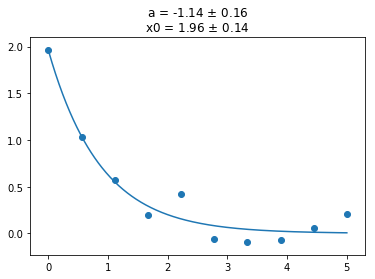

In [112]:
tdata = np.linspace(0,5,10)
a = -1-0.1*np.random.random()
x0 = 5 * np.random.random() + 1
print(a,x0)
eps = -a/2
xdata = [np.exp(a*t)*x0 + eps*(np.random.random() - 0.5) for t in tdata] 

def residual(params,t,x):
    f = lambda x, t : params['a']*x
    xsol = spi.odeint(f,[params['x0']],t)
    errs = [ a - b for a,b in zip(xsol,x)]
    return np.array(errs).flatten()

p = Parameters()
p.add('a', value=-1,max=0)
p.add('x0', value=1)

result = minimize(residual,p,args=(tdata,xdata))

tvals = np.linspace(0,max(tdata),420)
plt.plot(tvals,result.params['x0']*np.exp(result.params['a'] * tvals))
plt.scatter(tdata,xdata);
plt.title("a = %.2f $\pm$ %.2f\nx0 = %.2f $\pm$ %.2f" % (
    result.params['a'].value, result.params['a'].stderr,
    result.params['x0'].value,result.params['x0'].stderr
));

# Fitting a Chemical Reaction Network

In [245]:
# The network

species = var("x y z")
params = var("k1 k2")
v = make_vectorizer(species)
rxns = [
    [v(x,y),v(z),k1], # X+Y -k1-> Z
    [v(z,z),v(x),k2]  # 2Z -k2-> X
]
dyn = Dynamics(rxns,species)

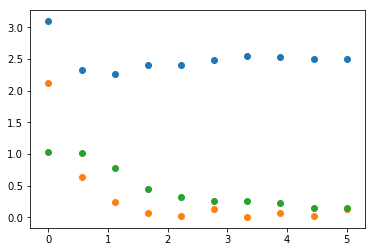

In [246]:
# Some fake data

f = ODEs(dyn.subs([(k1,1),(k2,1)]),species)
tdata = np.linspace(0,5,10)
xdata = spi.odeint(f,[3,2,1],tdata);
noise = lambda : [0.15*np.random.random() for i in [1,2,3]]
xdata = np.array([v+noise() for v in xdata])
plt.scatter(tdata,xdata[:,0])
plt.scatter(tdata,xdata[:,1])
plt.scatter(tdata,xdata[:,2]);

In [247]:
# define a residual fit the data

from lmfit import minimize, Parameters

def residual(pars,t,x):
    params = pars.valuesdict()
    f = ODEs(dyn.subs(k1,params["k1"]).subs(k2,params["k2"]),species)
    v0 = [params["x0"],params["y0"],params["z0"]]
    sol = spi.odeint(f,v0,t)
    # make a list of errors for all species and all time points
    errs  = [ a - b for a,b in zip(sol[:,0],x[:,0]) ] # X
    errs += [ a - b for a,b in zip(sol[:,1],x[:,1]) ] # Y
    errs += [ a - b for a,b in zip(sol[:,1],x[:,1]) ] # Z
    return errs

params = Parameters()
params.add('k1', value=1, min=0.0)
params.add('k2', value=1, min=0.0)
params.add('x0', value=1, min=0.0)
params.add('y0', value=1, min=0.0)
params.add('z0', value=1, min=0.0)
    
result = minimize(residual,params,args=(tdata,xdata))

result.params

name,value,standard error,relative error,initial value,min,max,vary
k1,0.84708279,0.04283763,5.06%,1,0.00000000,inf,True
k2,0.64992963,0.17103176,26.32%,1,0.00000000,inf,True
x0,3.10095397,0.05876134,1.89%,1,0.00000000,inf,True
y0,2.11575117,0.04141255,1.96%,1,0.00000000,inf,True
z0,1.18508663,0.14855166,12.54%,1,0.00000000,inf,True


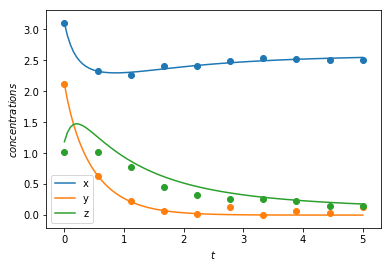

In [249]:
# plot the result

param_vals = [(k1,result.params['k1']),(k2,result.params['k2'])]
x0 = [ result.params[w] for w in [ 'x0', 'y0', 'z0' ] ]
f = ODEs(dyn.subs(param_vals),species)
t = np.linspace(0,max(tdata),100)
x = spi.odeint(f,x0,t);
plots = plt.plot(t,x);
plt.scatter(tdata,xdata[:,0])
plt.scatter(tdata,xdata[:,1])
plt.scatter(tdata,xdata[:,2]);
plt.xlabel('$t$');
plt.ylabel('$concentrations$');
plt.legend(plots,species);

In [244]:
result.params['k1'].stderr

0.0608347091039

# Working With Replicates

In [250]:
# Another network
species = var("x y")
params = var("k1 k2 k3 k4")
v = make_vectorizer(species)
rxns = [
    [v(),v(x),k1], 
    [v(x),v(),k2],
    [v(x),v(y),k3],
    [v(x,x,y),v(x,x,x),k4]
]
dyn = Dynamics(rxns,species)

t	| y	| error
--------------------------
0.00	| 1.39	| 0.40
0.77	| 2.50	| 0.22
1.54	| 2.69	| 0.96
2.31	| 3.52	| 0.92
3.08	| 2.73	| 0.82
3.85	| 4.52	| 0.45
4.62	| 4.41	| 0.81
5.38	| 4.36	| 0.67
6.15	| 4.10	| 0.57
6.92	| 0.64	| 0.47
7.69	| 1.79	| 0.64
8.46	| 2.33	| 0.58
9.23	| 2.76	| 0.43
10.00	| 2.37	| 0.16


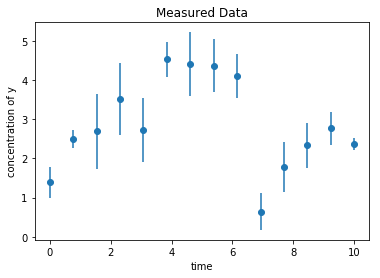

In [414]:
# Some fake data

f = ODEs(dyn.subs([(k1,1),(k2,1),(k3,3),(k4,1)]),species)
tdata = np.linspace(0,10,14)
xdata = spi.odeint(f,[1,1],tdata);

noise = lambda e : [e*(np.random.random()-0.5) for i in [1,2]]

ydata1 = np.array([v+noise(2) for v in xdata])[:,1]
ydata2 = np.array([v+noise(3) for v in xdata])[:,1]
ydata3 = np.array([v+noise(4) for v in xdata])[:,1]

means = ( ydata1 + ydata2 + ydata3 ) / 3
stdevs = np.sqrt(( (ydata1 - means)**2 + (ydata2 - means)**2 + (ydata3 - means)**2 ) / 2)
stderrs = stdevs/np.sqrt(3)

plt.errorbar(tdata,means,stderrs, fmt='o')
plt.xlabel("time")
plt.ylabel("concentration of y")
plt.title("Measured Data");

print("t\t| y\t| error")
print("--------------------------")
[print("%0.2f\t| %0.2f\t| %0.2f" % (t,m,e)) for t,m,e in zip(tdata,means,stderrs)];

In [415]:
# define a residual and fit the data

from lmfit import minimize, Parameters

def residual(pars,t,x,stderrs):
    params = pars.valuesdict()
    f = ODEs(dyn
             .subs(k1,params["k1"])
             .subs(k2,params["k2"])
             .subs(k3,params["k3"])
             .subs(k4,params["k4"]),species)
    v0 = [params["x0"],params["y0"]]
    sol = spi.odeint(f,v0,t)
    errs  = np.array([ ( a - b )/e  for a,b,e in zip(sol[0:,1],x,stderrs) ])
    return errs

params = Parameters()

params.add('k1', value=1, min=0.0, max=10)
params.add('k2', value=1, min=0.0, max=10)
params.add('k3', value=1, min=0.0, max=10)
params.add('k4', value=1, min=0.0, max=10)
params.add('x0', value=1, min=0.0, max=10)
params.add('y0', value=1, min=0.0, max=10)
    
result = minimize(residual,params,args=(tdata,means,stderrs)) #,method='differential_evolution')

result.params

name,value,standard error,relative error,initial value,min,max,vary
k1,0.91029373,0.24527645,26.94%,1,0.00000000,10.0000000,True
k2,0.53675087,0.06799226,12.67%,1,0.00000000,10.0000000,True
k3,2.08292803,0.67007414,32.17%,1,0.00000000,10.0000000,True
k4,0.48981272,0.28395057,57.97%,1,0.00000000,10.0000000,True
x0,1.09953405,2.05607569,187.00%,1,0.00000000,10.0000000,True
y0,1.54071133,0.41698082,27.06%,1,0.00000000,10.0000000,True


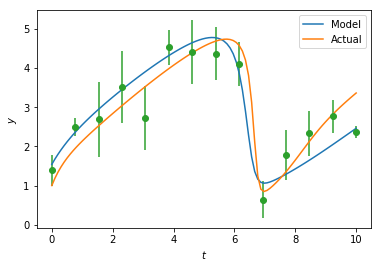

In [416]:
param_vals = [
    (k1,result.params['k1']),
    (k2,result.params['k2']),
    (k3,result.params['k3']),
    (k4,result.params['k4'])]

actual_param_vals = [
    (k1,1),
    (k2,1),
    (k3,3),
    (k4,1)]

x0 = [ result.params[w] for w in [ 'x0', 'y0' ] ]
f = ODEs(dyn.subs(param_vals),species)
fa = ODEs(dyn.subs(actual_param_vals),species)
t = np.linspace(0,max(tdata),100)
x = spi.odeint(f,x0,t);
xa = spi.odeint(fa,[1,1],t);
plots = plt.plot(t,x[:,1],t,xa[:,1]);
plt.errorbar(tdata,means,stderrs, fmt='o')
plt.xlabel('$t$');
plt.ylabel('$y$');
plt.legend(plots,["Model", "Actual"]);